In [1]:
from mlclasses_f3dasm import LinearRegression, MLArchitecture, get_reshaped_array_from_list_of_arrays, get_flat_array_from_list_of_arrays
import tensorflow as tf
import f3dasm
import numpy as np
from typing import List, Tuple
from copy import copy
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

2022-12-21 16:43:19.543408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 16:43:19.710181: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-21 16:43:20.418131: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:/usr/local/cuda-11.1/lib64
2022-12-21 16:43:20.418189: W ten

In [2]:
class Function: # Dit moet eigenlijk een soort Function worden, maar dan met een ML architectuur en Data ...
    def __init__(self, model: MLArchitecture, data: f3dasm.Data):
        self.model = model
        self.data = data
        
    def evaluate(self, x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]: # Two 2D arrays: loss (1,1), grad (dim, 1)

        self.model.set_model_weights(x)

        with tf.GradientTape() as tape:
            loss = self.model.loss(self.model(self.data.get_input_data().to_numpy()), self.data.get_output_data().to_numpy())
        grads = tape.gradient(loss, self.model.trainable_variables)
        return np.atleast_2d(loss.numpy()), get_flat_array_from_list_of_arrays(grads)

    def f(self, x: np.ndarray):
        loss, _ = self.evaluate(x)
        return loss

    def dfdx(self, x: np.ndarray):
        _, grads = self.evaluate(x)
        return grads


In [3]:
class SGD:
    def __init__(self, data: f3dasm.Data, lr: float = 0.03):
        self.data = data
        self.lr = lr

    def update_step(self, function: Function) -> np.ndarray:

        x = np.atleast_2d(self.data.get_input_data().iloc[-1].to_numpy()).T
        g = function.dfdx(function.model.get_model_weights())

        x_update = x - (self.lr * g)
        y_update = function.f(x_update)
        return x_update, y_update

    def iterate(self, iterations: int, function: Function):
        for _ in range(iterations):
            
            # Optimization update
            x_update, y_update = self.update_step(function=function)
            
             # Evaluate new parameters
            # loss_update = function.f(x_update)

            # Add to model dataframe
            self.data.add_numpy_arrays(input=x_update.T, output=y_update)

    def extract_data(self) -> f3dasm.Data:
        return copy(self.data)
        

        

In [4]:
def create_regression_data(n: int, b: float, w: List[float], noise_multiplier: float = 0.01) -> f3dasm.Data:
    w = tf.constant(w, dtype=float)
    dim = len(w)
    num_train = n // 2
    num_val = n - num_train

    noise = tf.random.normal((n, 1)) * noise_multiplier

    X = tf.random.normal((n, w.shape[0])) # (num, dim)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b + noise # (1, dim)

    # Create designspace
    design = f3dasm.make_nd_continuous_design(bounds=np.tile([-np.inf,np.inf], (dim, 1)), dimensionality=dim)

    # Create Data object
    regression_data = f3dasm.Data(design)

    regression_data.add_numpy_arrays(input=X.numpy(), output=y.numpy())
    return regression_data

In [5]:
seed = 42

In [6]:
# Create data
dim = 3
random_weights = list(np.random.random(size=dim))
n = 2000
b = random_weights[0]
w = random_weights[1:] # [2, -3.4, 5., 6.7, -3.4, 6]
reg_data = create_regression_data(n=n, b=b, w=w, noise_multiplier=1)
reg_data.data

# Create model parameter data
design = f3dasm.make_nd_continuous_design(bounds=np.tile([-10.,10.], (dim, 1)), dimensionality=dim) #these bounds are a guess!!

# Create sampler
sampler = f3dasm.sampling.LatinHypercube(design=design,seed=seed)

# Create model parameters
model_parameters = sampler.get_samples(numsamples=1)

2022-12-21 16:43:30.004710: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-21 16:43:30.004811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martin): /proc/driver/nvidia/version does not exist
2022-12-21 16:43:30.007178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Create regression model
model = LinearRegression(dimensionality=len(w))

# Create Function by combining regression data and a model
trainer = Function(model=model, data=reg_data)

# Evaluate the sample
model_parameters.add_output(output=trainer.f(model_parameters.get_input_data().to_numpy().ravel()))

In [8]:
iterations = 100


function = Function(model=model, data=reg_data)
optimizer = SGD(data=model_parameters)

optimizer.iterate(iterations, function)

dd = optimizer.extract_data()

# for _ in range(iterations):

#     #Calculate gradient
#     with tf.GradientTape() as tape:
#         loss = model.loss(model(reg_data.data['input'].to_numpy()), reg_data.data['output'].to_numpy())

#     grads = tape.gradient(loss, model.trainable_variables)

#     # Optimization update
#     w_hat = model.get_model_weights()
#     x_update = w_hat - (0.03 * get_flat_array_from_list_of_arrays(grads))

#     # Evaluate new parameters
#     model.set_model_weights(x_update)
#     loss_update = model.loss(model(reg_data.get_input_data().to_numpy()), reg_data.get_output_data().to_numpy())

#     # Add to model dataframe
#     model_parameters.add_numpy_arrays(input=x_update.T, output=np.atleast_2d(loss_update.numpy()))

In [9]:
# trainer.model.get_model_weights()

In [10]:
dd

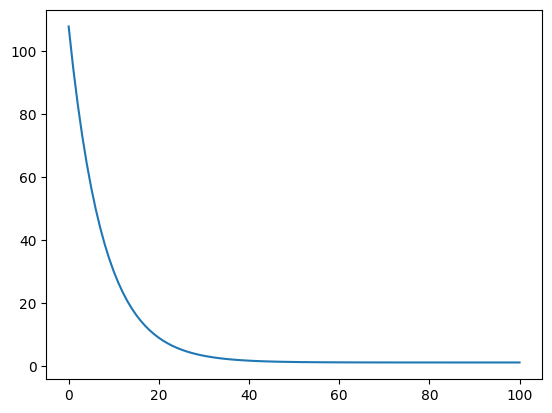

In [11]:
plt.plot(dd.get_output_data())

In [12]:
y, grad = function.evaluate(np.array([0.,0.,0.]))

In [13]:
y

array([[1.7185769]], dtype=float32)

In [14]:
grad

array([[-0.8968157],
       [-0.5788273],
       [-1.211842 ]], dtype=float32)